In [1]:
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
idx = pd.IndexSlice

In [3]:
from backtesting import perform_nav_backtest, PortfolioBacktest
from sharpe import calc_sharpe

In [4]:
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 1000

In [5]:
source_folder = 'files'

In [6]:
logging.basicConfig(level=logging.DEBUG, filename='task_2_nb.log', filemode='w')

# Reading data

## 10Y US Notes

In [7]:
ust = pd.read_csv(f'{source_folder}/ust_10y_yields_hist.csv')
ust['Date'] = pd.to_datetime(ust['Date'])
ust.set_index('Date', inplace=True)
ust.sort_index(ascending=True, inplace=True)

In [8]:
ust['Close'].describe()

count    9061.000000
mean        4.727160
std         2.321428
min         0.499000
25%         2.624000
50%         4.564000
75%         6.537000
max        10.230000
Name: Close, dtype: float64

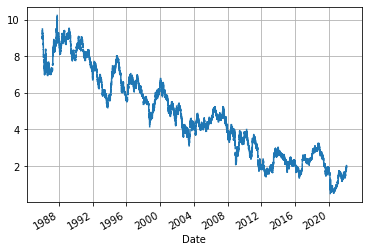

In [9]:
ust['Close'].plot()

plt.grid()
plt.show()

## Meta data

In [10]:
md = pd.read_csv(f'{source_folder}/meta_data.csv')

md = md[md.columns[1:]].copy()

In [11]:
_col = 'ticker'

if not md[_col].duplicated().any():
    md.set_index(_col, inplace=True)
else:
    raise Exception(f'There are duplicates in column {_col}')

In [12]:
md['sicsector'].value_counts()

Manufacturing                                                      122
Finance Insurance And Real Estate                                   71
Services                                                            37
Transportation Communications Electric Gas And Sanitary Service     30
Retail Trade                                                        15
Wholesale Trade                                                     11
Mining                                                              11
Construction                                                         3
Name: sicsector, dtype: int64

In [13]:
md['sector'].value_counts()

Industrials               52
Financial Services        52
Consumer Cyclical         44
Healthcare                40
Technology                39
Real Estate               18
Energy                    15
Basic Materials           13
Consumer Defensive        13
Utilities                 11
Communication Services     2
Name: sector, dtype: int64

In [14]:
md['table'].value_counts()

SF1    300
Name: table, dtype: int64

## Indicators descrition

In [15]:
desc = pd.read_csv(f'{source_folder}/indicators_description.csv')

desc.replace('Y', True, inplace=True)
desc.replace('N', False, inplace=True)

In [16]:
desc['table'].value_counts()

SF1           111
EVENTCODES     37
SF3A           29
SF3B           28
TICKERS        28
SF2            24
SFP            10
DAILY          10
SEP            10
SF3             7
ACTIONS         7
INDICATORS      7
SP500           7
EVENTS          3
Name: table, dtype: int64

In [17]:
_cols = ['table', 'indicator']
if not desc[_cols].duplicated().any():
    desc.set_index(_cols, inplace=True)
else:
    raise Excpetion('There are duplicates')

In [18]:
desc[desc['isprimarykey']]

isfilter  isprimarykey  \
table      indicator                              
SF1        ticker            True          True   
           dimension         True          True   
           datekey          False          True   
           reportperiod     False          True   
SF2        ticker            True          True   
           filingdate        True          True   
           formtype         False          True   
           ownername         True          True   
           rownum           False          True   
SF3        ticker            True          True   
           investorname      True          True   
           securitytype      True          True   
           calendardate      True          True   
SF3A       calendardate      True          True   
           ticker            True          True   
SFP        ticker            True          True   
           date              True          True   
ACTIONS    date              True          True   
           action            True          True   
           ticker            True          True   
           contraticker      True          True   
DAILY      ticker            True          True   
           date              True          True   
EVENTS     date              True          True   
           ticker            True          True   
INDICATORS table             True          True   
           indicator         True          True   
           isfilter          True          True   
           isprimarykey      True          True   
SEP        ticker            True          True   
           date              True          True   
SP500      date              True          True   
           action            True          True   
           ticker            True          True   
TICKERS    table             True          True   
           permaticker       True          True   
           ticker            True          True   

                                                   title  \
table      indicator                                       
SF1        ticker                          Ticker Symbol   
           dimension                           Dimension   
           datekey                              Date Key   
           reportperiod                    Report Period   
SF2        ticker                          Ticker Symbol   
           filingdate                        Filing Date   
           formtype                            Form Type   
           ownername     Owner Name (Insider / Investor)   
           rownum                             Row Number   
SF3        ticker                          Ticker Symbol   
           investorname      Institutional Investor Name   
           securitytype                    Security Type   
           calendardate                    Calendar Date   
SF3A       calendardate                    Calendar Date   
           ticker                          Ticker Symbol   
SFP        ticker                          Ticker Symbol   
           date                               Price Date   
ACTIONS    date                                     Date   
           action                                 Action   
           ticker                          Ticker Symbol   
           contraticker             Contra Ticker Symbol   
DAILY      ticker                          Ticker Symbol   
           date                               Price Date   
EVENTS     date                              Filing Date   
           ticker                          Ticker Symbol   
INDICATORS table                          Sharadar Table   
           indicator                      Indicator Code   
           isfilter                           Is Filter?   
           isprimarykey                  Is Primary Key?   
SEP        ticker                          Ticker Symbol   
           date                               Price Date   
SP500      date                                     Dat

In [19]:
desc.xs('table', level='indicator')

,isfilter,isprimarykey,title,description,unittype
table,,,,,
INDICATORS,True,True,Sharadar Table,"The database table which the ticker is featured in. Examples are: ""SF1"" or ""SEP"".\t",text
TICKERS,True,True,Sharadar Table,"The database table which the ticker is featured in. Examples are: ""SF1"" or ""SEP.",text


In [20]:
desc.xs('dimension', level='indicator')

,isfilter,isprimarykey,title,description,unittype
table,,,,,
SF1,True,True,Dimension,[Entity] The dimension field allows you to take different dimensional views of data over time. ARQ: Quarterly; excluding restatements; MRQ: Quarterly; including restatements; ARY: annual; excluding restatements; MRY: annual; including restatements; ART: trailing-twelve-months; excluding restatements; MRT: trailing-twelve-months; including restatements.,text


In [21]:
desc.xs('datekey', level='indicator')

,isfilter,isprimarykey,title,description,unittype
table,,,,,
SF1,False,True,Date Key,[Entity] The Date Key represents the SEC filing date for AR dimensions (ARQ;ART;ARY); and the [REPORTPERIOD] for MR dimensions (MRQ;MRT;MRY). In addition; this is the observation date used for [Price] based data such as [MarketCap]; [Price] and [PE].,date (YYYY-MM-DD)


In [22]:
desc.xs('calendardate', level='indicator')

,isfilter,isprimarykey,title,description,unittype
table,,,,,
SF1,True,False,Calendar Date,"[Entity] The Calendar Date represents the normalized [ReportPeriod]. This provides a common date to query for which is necessary due to irregularity in report periods across companies. For example; if the report period is ""2015-09-26""; the calendar date will be ""2015-09-30"" for quarterly and trailing-twelve-month dimensions (ARQ;MRQ;ART;MRT); and ""2015-12-31"" for annual dimensions (ARY;MRY). We also employ offsets in order to maximise comparability of the period across companies. For example consider two companies: one with a quarter ending on 2018-07-24; and the other with a quarter ending on 2018-06-28. A naive normalization process would assign these to differing calendar quarters of 2018-09-30 and 2018-06-30 respectively. However, we assign these both to the 2018-06-30 calendar quarter because this maximises the overlap in the report periods in question and therefore the comparability of this period.",date (YYYY-MM-DD)
SF3,True,True,Calendar Date,The calendar date field represents the last day of the calendar quarter.,date (YYYY-MM-DD)
SF3A,True,True,Calendar Date,The calendar date field represents the last day of the calendar quarter.,date (YYYY-MM-DD)
SF3B,True,False,Calendar Date,The calendar date field represents the last day of the calendar quarter.,date (YYYY-MM-DD)


In [23]:
desc.xs('reportperiod', level='indicator')

,isfilter,isprimarykey,title,description,unittype
table,,,,,
SF1,False,True,Report Period,[Entity] The Report Period represents the end date of the fiscal period.,date (YYYY-MM-DD)


In [24]:
desc[desc.index.get_level_values('indicator').str.contains('asset')]

isfilter  isprimarykey               title  \
table indicator                                                   
SF1   assets            False         False        Total Assets   
      taxassets         False         False          Tax Assets   
      assetsc           False         False      Current Assets   
      assetsnc          False         False  Assets Non-Current   
      assetsavg         False         False      Average Assets   
      assetturnover     False         False      Asset Turnover   

                                                                                                                                                                                                                           description  \
table indicator                                                                                                                                                                                                                          
SF1   assets         [Balance Sheet] Sum of the carrying amounts as of the balance sheet date of all assets that are recognized. Major components are [CashnEq]; [Investments];[Intangibles]; [PPNENet];[TaxAssets] and [Receivables].   
      taxassets                                                                                                                                       [Balance Sheet] A component of [Assets] representing tax assets and receivables.   
      assetsc                                                                 [Balance Sheet] The current portion of [Assets]; reported if a company operates a classified balance sheet that segments current and non-current assets.   
      assetsnc                            [Balance Sheet] Amount of non-current assets; for companies that operate a classified balance sheet. Calculated as the different between Total Assets [Assets] and Current Assets [AssetsC].   
      assetsavg                                                                                                            [Metrics] Average asset value for the period used in calculation of [ROE] and [ROA]; derived from [Assets].   
      assetturnover                                                  [Metrics] Asset turnover is a measure of a firms operating efficiency; calculated by dividing [Revenue] by [AssetsAVG]. Often a component of DuPont ROE analysis.   

                     unittype  
table indicator                
SF1   assets         currency  
      taxassets      currency  
      assetsc        currency  
      assetsnc       currency  
      assetsavg      currency  
      assetturnover         %

In [25]:
desc[desc.index.get_level_values('indicator').str.contains('date')]

isfilter  isprimarykey              title  \
table   indicator                                                    
SF1     calendardate         True         False      Calendar Date   
        datekey             False          True           Date Key   
        lastupdated          True         False  Last Updated Date   
SF2     filingdate           True          True        Filing Date   
        transactiondate     False         False   Transaction Date   
        dateexercisable     False         False   Date Exercisable   
        expirationdate      False         False    Expiration Date   
SF3     calendardate         True          True      Calendar Date   
SF3A    calendardate         True          True      Calendar Date   
SF3B    calendardate         True         False      Calendar Date   
SFP     date                 True          True         Price Date   
        lastupdated          True         False  Last Updated Date   
ACTIONS date                 True          True               Date   
DAILY   date                 True          True         Price Date   
        lastupdated          True         False  Last Updated Date   
EVENTS  date                 True          True        Filing Date   
SEP     date                 True          True         Price Date   
        lastupdated          True         False  Last Updated Date   
SP500   date                 True          True               Date   
TICKERS lastupdated          True         False  Last Updated Date   
        firstpricedate      False         False   First Price Date   
        lastpricedate       False         False    Last Price Date   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   description  \
table   indicator                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
SF1     calendardate     [Entity] The Calendar Date represents the normalized [ReportPeriod]. This provides a common date to query for which is necessary due to irregularity in report periods across companies. For example; if the report period is "2015-09-26"; the calendar date will be "2015-09-30" for quarterly and trailing-twelve-month dimensions (ARQ;MRQ;ART;MRT); and "2015-12-31" for annual dimensions (ARY;MRY). We also employ offsets in order 

In [26]:
desc[desc.index.get_level_values('indicator').str.contains('pe', case=False)]

isfilter  isprimarykey  \
table      indicator                                          
SF1        opex                         False         False   
           capex                        False         False   
           pe                           False         False   
           pe1                          False         False   
           reportperiod                 False          True   
SF2        formtype                     False          True   
           istenpercentowner            False         False   
           transactionpricepershare     False         False   
SF3        securitytype                  True          True   
SF3A       percentoftotal               False         False   
SF3B       percentoftotal               False         False   
SFP        open                         False         False   
DAILY      pe                           False         False   
INDICATORS unittype                     False         False   
SEP        open                         False         False   
TICKERS    permaticker                   True          True   

                                                                                          title  \
table      indicator                                                                              
SF1        opex                                                              Operating Expenses   
           capex                                                            Capital Expenditure   
           pe                                                 Price Earnings (Damodaran Method)   
           pe1                                                          Price to Earnings Ratio   
           reportperiod                                                           Report Period   
SF2        formtype                                                                   Form Type   
           istenpercentowner                                              Is Ten Percent Owner?   
           transactionpricepershare                                 Transaction Price per Share   
SF3        securitytype                                                           Security Type   
SF3A       percentoftotal            Percentage of Total Institutional Holdings for the Quarter   
SF3B       percentoftotal            Percentage of Total Institutional Holdings for the Quarter   
SFP        open                                                     Open Price - Split Adjusted   
DAILY      pe                                         Price Earnings (Damodaran Method) - Daily   
INDICATORS unittype                                                         Indicator Unit Type   
SEP        open                                                     Open Price - Split Adjusted   
TICKERS    permaticker                                                  Permanent Ticker Symbol   

                                                                                                                                                                                                                                                                                                                                                                                                                    description  \
table      indicator                                                                                                                                                                                                                                                                                                                                                                                                              
SF1        opex                                                                                                                                                                                                                                                                   [Income

In [27]:
desc[desc.index.get_level_values('indicator').str.contains('ps', case=False)]

isfilter  isprimarykey  \
table   indicator                           
SF1     eps           False         False   
        epsdil        False         False   
        epsusd        False         False   
        dps           False         False   
        sps           False         False   
        ps1           False         False   
        ps            False         False   
        fcfps         False         False   
        bvps          False         False   
        tbvps         False         False   
DAILY   ps            False         False   
TICKERS cusips        False         False   

                                                    title  \
table   indicator                                           
SF1     eps                      Earnings per Basic Share   
        epsdil                 Earnings per Diluted Share   
        epsusd             Earnings per Basic Share (USD)   
        dps              Dividends per Basic Common Share   
        sps                               Sales per Share   
        ps1                          Price to Sales Ratio   
        ps                 Price Sales (Damodaran Method)   
        fcfps                    Free Cash Flow per Share   
        bvps                         Book Value per Share   
        tbvps        Tangible Assets Book Value per Share   
DAILY   ps         Price Sales (Damodaran Method) - Daily   
TICKERS cusips                                     CUSIPs   

                                                                                                                                                                                                                    description  \
table   indicator                                                                                                                                                                                                                 
SF1     eps                    [Income Statement] Earnings per share as calculated and reported by the company. Approximates to the amount of [NetIncCmn] for the period per each [SharesWA] after adjusting for [ShareFactor].   
        epsdil     [Income Statement] Earnings per diluted share as calculated and reported by the company. Approximates to the amount of [NetIncCmn] for the period per each [SharesWADil] after adjusting for [ShareFactor]..   
        epsusd                                                                                                                                                           [Income Statement] [EPS] in USD; converted by [FXUSD].   
        dps                                                    [Income Statement] Aggregate dividends declared during the period for each split-adjusted share of common stock outstanding. Includes spinoffs where identified.   
        sps                                                                                                      [Metrics] Sales per Share measures the ratio between [RevenueUSD] and [SharesWA] as adjusted by [ShareFactor].   
        ps1                                                                                            [Metrics] An alternative calculation method to [PS]; that measures the ratio between a company's [Price] and it's [SPS].   
        ps                                                                                                                                                   [Metrics] Measures the ratio between [MarketCap] and [RevenueUSD].   
        fcfps                                                                                            [Metrics] Free Cash Flow per Share is a valuation metric calculated by dividing [FCF] by [SharesWA] and [ShareFactor].   
        bvps                                                                                                                         [Metrics] Measures the ratio between [Equity] and [SharesWA] as adjusted by [ShareFactor].   
        tbvps                       

## Fundamental data

In [28]:
fd = pd.read_csv(f'{source_folder}/fundamental_data.csv')

fd = fd[fd.columns[1:]].copy()

fd.sort_index(ascending=True, inplace=True)

_cols = ['datekey', 'calendardate', 'reportperiod', 'lastupdated']
for _col in _cols:
    fd[_col] = pd.to_datetime(fd[_col])

In [29]:
_cols = ['ticker', 'dimension', 'datekey']
if not fd[_cols].duplicated().any():
    fd.set_index(_cols, inplace=True)
else:
    raise Exception('There are duplicates')

In [30]:
fd.index.get_level_values('dimension').value_counts()

MRT    28051
MRQ    27648
ART    26977
ARQ    26851
MRY     7393
ARY     6982
Name: dimension, dtype: int64

## Quotes

In [31]:
path = f'{source_folder}/data'
files_paths = glob.glob(path + '/*')

In [32]:
len(files_paths)

299

In [33]:
_qts = {}
for file_path in files_paths:
    file_name = file_path.split('/')[-1].split('.')[0]
    
    _df = pd.read_csv(file_path).set_index('Date').copy()
    _qts[file_name] = _df.set_index(pd.to_datetime(_df.index))

qts = pd.concat(_qts, names=['Ticker', 'Date'])
qts = qts.reset_index().set_index(['Date', 'Ticker'])['Close'].sort_index(ascending=True).copy()

In [34]:
if qts.index.duplicated().any():
    raise Exception('There are duplicates in the index')

## Removing securities from `fd` for which there's no quotes

In [35]:
set(qts.index.get_level_values('Ticker')) - set(fd.index.get_level_values('ticker'))

set()

In [36]:
set(fd.index.get_level_values('ticker')) - set(qts.index.get_level_values('Ticker'))

{'INGR'}

In [37]:
fd = fd.loc[idx[:, (~ fd.index.get_level_values('ticker').isin(_)), :]].copy()

## Creating `fd`-based dfs

### AR dimension only

In [38]:
fd_ar = fd[fd.index.get_level_values('dimension').str.contains('^AR.', regex=True)].copy()

In [39]:
# fd_ar.reset_index().set_index('datekey').groupby(['ticker', 'dimension']).resample('D', axis='index').ffill()

### Resampling

In [40]:
dimensions = fd_ar.index.get_level_values('dimension').unique()
_fd_ar_res = {dimension:
              fd_ar.xs(dimension, level='dimension').reset_index().set_index('datekey').groupby('ticker').\
                  resample('D').ffill()
              for dimension in dimensions}

fd_ar_res = pd.concat(_fd_ar_res, axis='index', join='outer', ).copy()
fd_ar_res.index.names = ['dimension'] + list(fd_ar_res.index.names[1:])

# Constants & params

In [41]:
capital = 1e6
lower_freq = 5

start_date = '1999-01-01'
end_date = '2020-05-01'

fdf = fd_ar_res.loc[idx[:, :, start_date:end_date]]  # f for filtered

In [42]:
quotes = qts.unstack('Ticker')[start_date:end_date].ffill()
dates = quotes.index
securities = quotes.columns
max_loan = 0
cashflows = None

if securities.duplicated().any() or dates.duplicated().any():
    raise Exception('There are duplicates')

# Ratio strategy

In [43]:
dim = 'ART'

numerator = 'revenue'
denominator = 'assets'

_cols = [numerator, denominator, 'ps']
ratio_df = fdf.xs(dim)[_cols]
ratio_df = \
    ratio_df.merge(md['sector'], how='left',
                   left_on=ratio_df.index.get_level_values('ticker'), right_index=True)
ratio_df = ratio_df.reset_index().set_index(['datekey', 'ticker']).sort_index(ascending=True).copy()

In [44]:
growth_sectors = ['Technology', 'Communication Services']
value_sectors = list(set(md['sector'].values) - set(growth_sectors))
value_sectors.remove(np.nan)

ratio_df['ratio #1'] = ratio_df[numerator] / ratio_df[denominator]

ratio_df.loc[ratio_df['sector'].isin(value_sectors), 'ratio'] = \
    ratio_df[ratio_df['sector'].isin(value_sectors)]['ratio #1']
ratio_df.loc[ratio_df['sector'].isin(growth_sectors), 'ratio'] = \
    ratio_df[ratio_df['sector'].isin(growth_sectors)]['ps']

In [45]:
# ratio = fdf.xs(dim)[numerator] / fdf.xs(dim)[denominator]
ratio = ratio_df['ratio #1']

ratio = ratio.reset_index().set_index(['datekey', 'ticker']).sort_index(ascending=True).iloc[:, 0].copy()
ratio = ratio.unstack('ticker').stack(dropna=False).sort_index(ascending=True).copy()

# ratio = ratio.groupby('datekey').apply(lambda _ser: (_ser - _ser.mean()) / _ser.std()).copy()

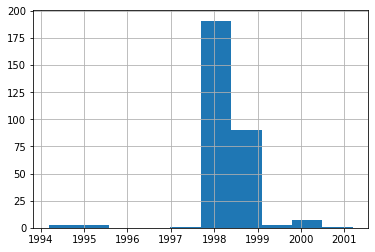

In [46]:
fd_ar_res.xs(dim)[numerator].groupby('ticker').apply(lambda _ser: _ser.first_valid_index()[1]).hist()

plt.show()

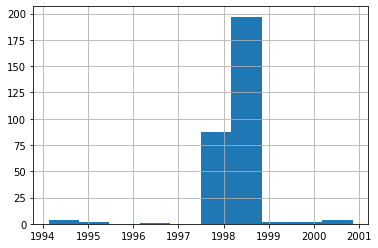

In [47]:
fd_ar_res.xs(dim)[denominator].groupby('ticker').apply(lambda _ser: _ser.first_valid_index()[1]).hist()

plt.show()

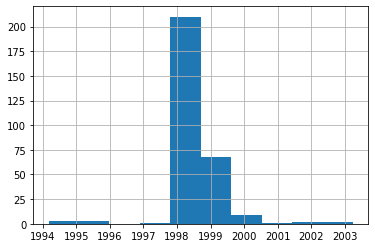

In [48]:
fd_ar_res.xs(dim)['ps'].groupby('ticker').apply(lambda _ser: _ser.first_valid_index()[1]).hist()

plt.show()

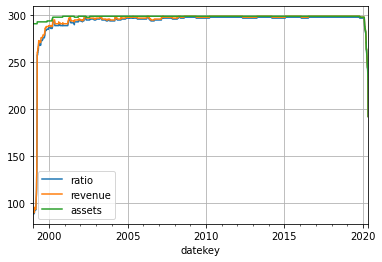

In [49]:
ratio_df['ratio'].groupby('datekey').apply(lambda _ser: (~ _ser.isna()).sum()).plot(label='ratio')
fdf.xs(dim)[numerator].groupby('datekey').apply(lambda _ser: (~ _ser.isna()).sum()).plot()
fdf.xs(dim)[denominator].groupby('datekey').apply(lambda _ser: (~ _ser.isna()).sum()).plot()

plt.legend()
plt.grid()
plt.show()

In [50]:
ratio[ratio < 0]

datekey     ticker
2008-02-29  MBI      -0.005959
2008-03-01  MBI      -0.005959
2008-03-02  MBI      -0.005959
2008-03-03  MBI      -0.005959
2008-03-04  MBI      -0.005959
                        ...   
2018-03-28  MBOT     -0.006933
2018-03-29  MBOT     -0.006933
2018-03-30  MBOT     -0.006933
2018-03-31  MBOT     -0.006933
2018-04-01  MBOT     -0.006933
Length: 3527, dtype: float64

In [51]:
ratio[ratio < 0] = 0

In [52]:
(ratio.groupby('datekey').apply(lambda _ser: (~ _ser.isna()).sum()) == 0).any()

False

In [53]:
ratio_n = ratio.groupby('datekey').apply(lambda _ser: _ser / _ser.sum())

eps = 1e-5
((ratio_n.groupby('datekey').sum() - 1).abs() < eps).all()

True

## Logic

In [54]:
class RatioStrategyBacktest(PortfolioBacktest):
    def __init__(self,
                 ratio: pd.Series,
                 eps_ratio: float = 1e-10,
                 *args,
                 **kwargs):
        super().__init__(*args, **kwargs)
        
        self.ratio = ratio.sort_index().copy()
        if (self.ratio < 0).any():
            logger.warning('There are negative values in ratio series')
        
        self.ratio_n = self.ratio.groupby('datekey').apply(lambda _ser: _ser / _ser.sum()).copy()
        if not ((self.ratio_n.groupby('datekey').sum() - 1).abs() < eps_ratio).all():
            logger.warning('Normalized ratio sum != 1 for some dates')

In [55]:
class SalesToAssetsRatioBacktest(RatioStrategyBacktest):
    def run_strategy(self):
        logger = logging.getLogger(f'{self.logger.name}.run_strategy')
        
        alloc_curr = self.allocation.iloc[0]
        alloc_curr = alloc_curr.drop(index='ABC', inplace=True)
        
        for i, date in enumerate(self.dates[:-1]):
            next_date = self.dates[i + 1]
            
            alloc_curr = self.allocation.loc[date].drop('cash')
            alloc_new = self.ratio_n.xs(date)
#             alloc_new['cash'] = 0
            
            if (alloc_curr != alloc_new).any():
                alloc_change = alloc_new - alloc_curr
                value_change = alloc_change * self.nav.loc[date]
                positions_change = value_change / self.quotes.loc[date]
                
                logger.debug(f'date: {date}, next_date: {next_date}. '
                             f'alloc_new[alloc_new < 0]: {alloc_new[alloc_new < 0].to_dict()}')
                
                rebalance_prices = self.quotes.loc[next_date]
                
                self.do_rebalance(date,
                                  next_date,
                                  positions_change=positions_change,
                                  rebalance_prices=rebalance_prices)

## Backtest

In [56]:
ini_positions = None
eps_ratio = 1e-10

my_strat_backtest = SalesToAssetsRatioBacktest(securities=securities,
                                               dates=dates,
                                               quotes=quotes,
                                               cashflows=cashflows,
                                               capital=capital,
                                               ini_positions=ini_positions,
                                               max_loan=max_loan,
                                               lower_freq=lower_freq,
                                               ratio=ratio,
                                               eps_ratio=eps_ratio)

In [57]:
%%time

my_strat_backtest.run_strategy()

CPU times: user 2min 8s, sys: 18.7 s, total: 2min 26s
Wall time: 2min 41s


In [58]:
my_strat_backtest.allocation

,ABC,ABCP,ABMD,ACY,AEP,AGHC,AJG,ALB,ALL,AMAG,AMSC,AMTD,AMWD,ANIK,ANSS,...,WGO,WHR,WPC,WRE,WSTG,WTM,WTRG,WVFC,WVVI,WWD,WYY,XLNX,YRCW,ZEUS,cash
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-01-04,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1999-01-05,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1999-01-06,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1999-01-07,0.059131,0.0,0.005736,0.000000,0.000000,0.025327,0.000000,0.000000,0.000000,0.001842,0.002588,0.001131,0.023043,0.000000,0.000000,...,0.022074,0.012262,0.001085,0.000000,0.000000,0.000000,0.000000,0.000356,0.000000,0.008993,0.000000,0.006606,0.000000,0.000000,0.001071
1999-01-08,0.057152,0.0,0.005902,0.000000,0.000000,0.024047,0.000000,0.000000,0.000000,0.001842,0.002513,0.001182,0.023140,0.000000,0.000000,...,0.022836,0.012563,0.001089,0.000000,0.000000,0.000000,0.000000,0.000358,0.000000,0.008734,0.000000,0.006615,0.000000,0.000000,0.001071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-27,0.025862,0.0,0.003534,0.000179,0.000987,0.002847,0.001632,0.002030,0.001727,0.001277,0.001739,0.000816,0.002567,0.001165,0.002340,...,0.010297,0.003742,0.000271,0.000476,0.009459,0.000908,0.000458,0.000090,0.001531,0.001884,0.010432,0.003148,0.006013,0.008096,0.000300
2020-04-28,0.025389,0.0,0.003538,0.000168,0.000994,0.003967,0.001621,0.002087,0.001698,0.001205,0.001722,0.000820,0.002720,0.001105,0.002280,...,0.010747,0.003884,0.000278,0.000488,0.009308,0.000903,0.000455,0.000089,0.001506,0.001980,0.010384,0.003030,0.006213,0.008023,0.000299
2020-04-29,0.024406,0.0,0.003509,0.000165,0.000941,0.004368,0.001611,0.002022,0.001700,0.001180,0.001744,0.000827,0.002851,0.001149,0.002269,...,0.010829,0.004026,0.000283,0.000490,0.009422,0.000889,0.000432,0.000086,0.001483,0.002059,0.010735,0.003116,0.006094,0.008334,0.000288


In [59]:
my_strat_backtest.allocation.ne(0).idxmax()

ABC    1999-01-07
ABCP   2003-04-08
ABMD   1999-01-07
ACY    1999-08-25
AEP    1999-08-25
          ...    
WYY    1999-08-25
XLNX   1999-01-07
YRCW   1999-08-25
ZEUS   1999-08-25
cash   1999-01-04
Length: 300, dtype: datetime64[ns]

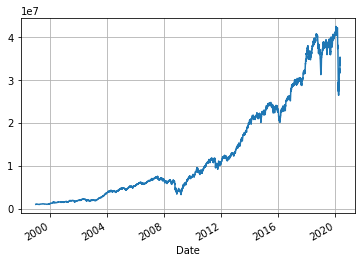

In [60]:
my_strat_backtest.nav.plot()

plt.grid()
plt.show()

In [61]:
my_strat_backtest.allocation['cash'].ne(1).idxmax()

Timestamp('1999-01-07 00:00:00')

In [62]:
(my_strat_backtest.ratio_n < 0).any()

False

## Evaluating aggregate portfolio results

In [63]:
annualization_factor = 360

portf_res_ms = perform_nav_backtest(my_strat_backtest.nav, ust['Close'] / 100, risk_free_annualized=True,
                                annualization_factor=annualization_factor).copy()

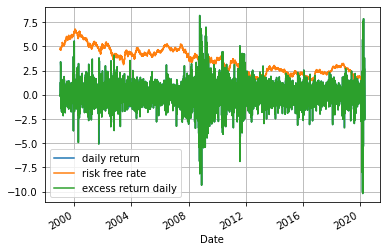

In [64]:
_cols = ['daily return', 'risk free rate', 'excess return daily']
_data = portf_res_ms[_cols] * 100
_data.plot()

plt.grid()
plt.show()

### Return

In [65]:
portf_res_ms['total return'].iloc[-1]

32.52290428149775

### CAGR

In [66]:
total_years = (portf_res_ms.index[-1] - portf_res_ms.index[0]) / np.timedelta64(1, 'Y')

(_ + 1) ** (1 / total_years) - 1

0.17905928769826884

In [67]:
total_years

21.3228197704265

### Sharpe

In [68]:
calc_sharpe(portf_res_ms['excess return'].mean(),
            portf_res_ms['excess return'].std(),
            multiply_by=252 ** .5)

0.3068390033645452